In [1]:
%matplotlib inline
'''
How to Optimize Your Dragon: V5
Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, tray_translator, check_iteration# , check_violate_constraint
from utility.data_utility import cal_cnumber
from utility.time_utility import create_filename_time, log_now, log_end

2018-07-19 21:05:57 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'

In [3]:
with open('./log/model/stage_20_base_product.pickle','rb') as f:
    model = dill.load(f)

In [4]:
check_DOF(pe,model)

Active Equality Constraints:	 28997
Active Inequality Constraints:	 21
Active Variables:		 29462
Fixed Variables:		 392
DOF:				 73


# Add tray optimization related sets and variables

In [5]:
model.TRAY_total = pe.Set(initialize=['condenser']+[str(i) for i in model.TRAY]+['reboiler'],ordered=True)

In [6]:
model.sigma = pe.Param(initialize=0.005,mutable=True)

In [7]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
    return model.P_tray[j,p] * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total) \
            == model.P_total[p] * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma)
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == model.P_total[p]*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

In [11]:
check_DOF(pe,model)

Active Equality Constraints:	 29862
Active Inequality Constraints:	 21
Active Variables:		 30357
Fixed Variables:		 419
DOF:				 76


### Initialized newly created value

In [12]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [13]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [14]:
check_DOF(pe,model)

Active Equality Constraints:	 29862
Active Inequality Constraints:	 21
Active Variables:		 30357
Fixed Variables:		 422
DOF:				 73


In [15]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['output_file'] = './tmp/ipopt_output_tmp.output'
opt.options['constr_mult_init_max '] = 1e3
opt.options['max_iter'] = 500

opt.options['linear_solver'] = 'ma86'
opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'

opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20

opt.options['mu_init'] = 1e-6

In [16]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =1000.0
max_iter=500
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1000                  yes
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 

In [17]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-134.						3.0267	0.6407	0.0337		2.0654

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	119.3	0.000	0.0000	0.000	0.00	0.000		5.7667	0.7437	0.0000		20.000
NON--[2]	131.1	0.000	0.0000	0.000	0.00	0.000		5.8697	0.6752	0.0000		20.000
NON--[3]	140.3	0.000	0.0000	0.000	0.00	0.000		5.8012	0.6136	0.0000		20.000
NON--[4]	148.7	0.000	0.0000	0.000	0.00	0.000		5.7396	0.5249	0.0218		20.000
NON--[5]	157.3	0.000	0.0000	0.000	0.00	0.000		5.6727	0.4430	0.0000		20.000
NON--[6]	167.3	0.000	0.0000	0.000	0.00	0.000		5.5909	0.3311	0.0000		20.000
NON--[7]	181.1	0.000	0.0000	0.000	0.00	0.000		5.4790	0.1558	0.0389		20.000
React[8]	200.0	-24.4	0.1555	0.201	1.00	3000.		5.3427	0.

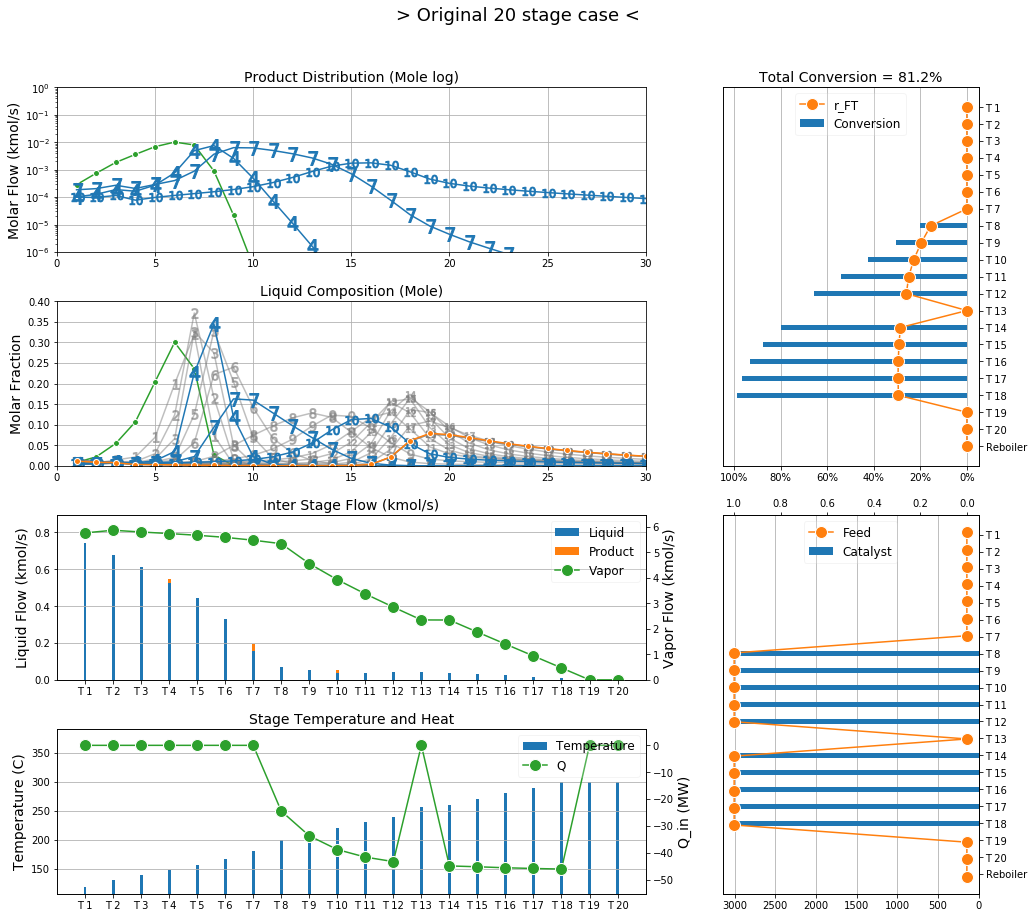

In [18]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Original 20 stage case')

# Optimization Input

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw ratio
    * PR_L: 0 - 1

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

### Open up parameters

In [19]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

In [20]:
model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [21]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

In [22]:
def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [23]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.P_total['gasoline'] - sum(model.reactive[j].MPCC.pf for j in model.reactive)\
                                - model.reboiler.MPCC.pf, sense = pe.maximize)

In [24]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =1000.0
max_iter=500
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1000                  yes
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 

  65 -1.0553081e-01 1.50e+00 2.31e+02  -6.0 1.45e+02    -  5.83e-01 1.00e+00h  1
  66 -1.0551488e-01 1.67e-02 9.98e+00  -6.0 2.92e+01    -  1.00e+00 1.00e+00h  1
  67 -1.0551429e-01 1.01e-05 6.76e-03  -6.0 7.12e-01    -  1.00e+00 1.00e+00h  1
  68 -1.0551429e-01 2.99e-10 1.12e-08  -6.0 3.11e-04    -  1.00e+00 1.00e+00h  1
  69 -1.0567371e-01 5.31e-01 2.46e+03  -9.0 1.97e+02    -  8.41e-01 8.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0566349e-01 3.48e-01 1.61e+03  -9.0 2.65e+01    -  7.47e-01 3.48e-01h  1
  71 -1.0565214e-01 1.59e-01 7.52e+02  -9.0 1.72e+01    -  9.59e-01 5.48e-01h  1
  72 -1.0564591e-01 6.27e-02 3.23e+02  -9.0 7.35e+00    -  9.68e-01 6.08e-01h  1
  73 -1.0564581e-01 6.12e-02 3.15e+02  -9.0 3.33e+00    -  1.00e+00 2.48e-02h  1
  74 -1.0564246e-01 1.15e-02 1.07e+02  -9.0 2.68e+00    -  1.00e+00 8.13e-01h  1
  75 -1.0564167e-01 4.51e-06 8.26e+01  -9.0 4.87e-01    -  1.00e+00 1.00e+00h  1
  76 -1.0564167e-01 2.86e-10


> Optimized Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-162.						2.1132	0.9770	0.0913		2.3384

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	132.4	0.000	0.0000	0.000	0.00	0.000		5.5201	1.2093	0.0000		20.000
NON--[2]	147.6	0.000	0.0000	0.000	0.00	0.000		5.7524	1.1552	0.0000		20.000
NON--[3]	158.2	0.000	0.0000	0.000	0.00	0.000		5.6983	1.1103	0.0000		20.000
NON--[4]	166.7	0.000	0.0000	0.000	0.00	0.000		5.6534	1.0491	0.0000		20.000
NON--[5]	175.0	0.000	0.0000	0.000	0.00	0.000		5.5922	0.9481	0.0000		20.000
NON--[6]	185.5	0.000	0.0000	0.000	0.00	0.000		5.4912	0.7685	0.0000		20.000
NON--[7]	202.5	0.000	0.0000	0.000	0.00	0.000		5.3116	0.4073	0.1056		20.000
React[8]	229.5	-32.2	0.2554	0.393	1.00	3000.		5.05

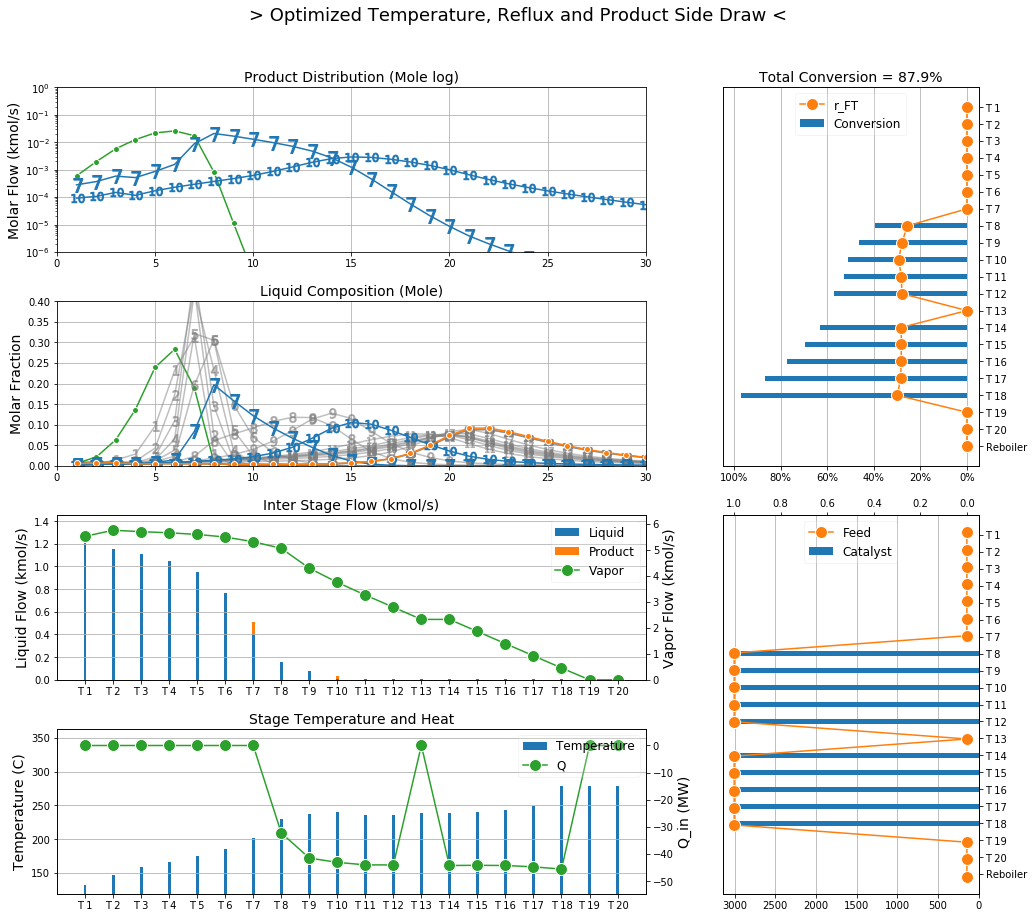

In [25]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Side Draw')

# Use DDF,  open up gasoline location

In [37]:
opt = None
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['output_file'] = './tmp/ipopt_output_tmp.output'
opt.options['constr_mult_init_max '] = 1e3
opt.options['max_iter'] = 500

opt.options['linear_solver'] = 'ma86'
#opt.options['linear_system_scaling '] = 'mc19'
#opt.options['linear_scaling_on_demand '] = 'yes'

opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20

opt.options['mu_init'] = 1e-6

In [26]:
# for j in model.reactive:
#     model.reactive[j].MPCC.pf.setub(0)
# model.reboiler.MPCC.pf.setub(0)

In [31]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [35]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =1000.0
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1000                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

******************************************************************************
This program contains Ipopt, a library 

  68 -1.0556226e-01 1.33e-07 3.07e-02  -6.0 1.92e-02  -1.6 1.00e+00 1.00e+00h  1
  69 -1.0556209e-01 1.25e-07 2.32e-01  -6.0 5.76e-02  -2.1 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0556205e-01 1.37e-07 7.17e-02  -6.0 2.16e-02  -1.6 1.00e+00 1.00e+00h  1
  71 -1.0556195e-01 1.26e-07 3.09e-02  -6.0 8.09e-03  -1.2 1.00e+00 1.00e+00h  1
  72 -1.0556185e-01 1.41e-07 1.29e-01  -6.0 2.43e-02  -1.7 1.00e+00 1.00e+00h  1
  73 -1.0556175e-01 1.33e-07 5.32e-02  -6.0 9.09e-03  -1.3 1.00e+00 1.00e+00h  1
  74 -1.0556161e-01 1.51e-07 2.05e-01  -6.0 2.73e-02  -1.7 1.00e+00 1.00e+00h  1
  75 -1.0556150e-01 1.45e-07 8.31e-02  -6.0 1.02e-02  -1.3 1.00e+00 1.00e+00h  1
  76 -1.0556132e-01 1.65e-07 3.06e-01  -6.0 3.06e-02  -1.8 1.00e+00 1.00e+00h  1
  77 -1.0556119e-01 1.61e-07 1.23e-01  -6.0 1.15e-02  -1.4 1.00e+00 1.00e+00h  1
  78 -1.0556097e-01 1.80e-07 4.40e-01  -6.0 3.44e-02  -1.8 1.00e+00 1.00e+00h  1
  79 -1.0556081e-01 1.78e-07

 161 -1.0552852e-01 2.48e-07 5.02e+02  -6.0 2.23e-02  -0.8 4.18e-01 1.00e+00h  1
 162 -1.0552642e-01 2.42e-07 1.23e+03  -6.0 1.57e-02  -0.4 2.30e-01 1.00e+00h  1
 163 -1.0553011e-01 2.49e-07 1.30e+03  -6.0 1.11e-01  -0.9 6.32e-02 2.85e-01h  1
 164 -1.0553319e-01 2.47e-07 1.27e+03  -6.0 3.80e-01  -1.3 9.62e-03 3.41e-02f  1
 165 -1.0553834e-01 4.67e-07 5.02e+02  -6.0 1.00e-01  -1.8 3.52e-02 2.04e-01f  1
 166 -1.0554232e-01 5.87e-07 4.29e+02  -6.0 2.78e-01  -2.3 2.08e-03 6.21e-02f  1
 167 -1.0555992e-01 2.16e-06 7.32e+03  -6.0 5.47e-01  -2.8 6.72e-05 1.42e-01f  1
 168 -1.0556696e-01 2.18e-06 4.59e+03  -6.0 2.87e-01  -2.3 1.71e-01 8.66e-02f  2
 169 -1.0560285e-01 4.14e-06 7.00e+03  -6.0 5.43e-01  -2.8 1.83e-01 2.43e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -1.0560767e-01 4.20e-06 2.21e+04  -6.0 1.07e+00  -3.3 2.36e-01 5.20e-02f  2
 171 -1.0560928e-01 4.19e-06 2.12e+04  -6.0 5.08e-01  -2.9 4.79e-02 4.44e-02h  2
 172 -1.0561280e-01 5.47e-06

 254 -1.2025440e-01 2.72e-02 3.20e+05  -6.0 4.63e+01  -4.5 1.11e-02 2.24e-02h  3
 255 -1.2025456e-01 2.67e-02 3.87e+05  -6.0 2.73e+00  -4.1 1.22e-01 1.93e-02h  4
 256 -1.2025457e-01 2.66e-02 4.28e+05  -6.0 1.66e+00  -3.7 1.71e-01 3.96e-03h  7
 257 -1.2025466e-01 2.64e-02 4.57e+05  -6.0 2.33e+00  -4.2 1.17e-01 7.86e-03h  6
 258 -1.2025672e-01 1.88e-02 3.14e+05  -6.0 1.25e+00  -3.7 8.82e-01 3.65e-01w  1
 259 -1.2026570e-01 1.69e-02 1.58e+05  -6.0 1.38e+00  -4.2 4.80e-01 5.26e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -1.2027538e-01 3.31e-02 1.31e+05  -6.0 3.48e+00  -4.7 4.62e-01 2.49e-01w  1
 261 -1.2025467e-01 2.64e-02 4.98e+05  -6.0 8.29e+00  -5.2 8.82e-01 1.43e-03h  8
 262 -1.2025613e-01 2.20e-02 4.00e+05  -6.0 9.89e-01  -3.8 2.27e-01 1.74e-01h  3
 263 -1.2025730e-01 2.08e-02 3.65e+05  -6.0 2.03e+00  -4.3 2.21e-01 6.94e-02h  4
 264 -1.2026411e-01 4.75e-03 1.29e+05  -6.0 9.15e-01  -3.9 3.90e-01 8.11e-01H  1
 265 -1.2027172e-01 5.23e-03

 347 -1.2696595e-01 8.87e-02 2.43e+04  -6.0 7.13e+01  -5.6 2.61e-04 7.33e-02h  1
 348 -1.2699712e-01 7.84e-02 3.49e+04  -6.0 9.66e+00  -5.1 2.22e-04 1.32e-01f  1
 349 -1.2687983e-01 6.79e-02 2.93e+04  -6.0 9.33e+00  -5.6 1.70e-01 1.43e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -1.2679366e-01 6.44e-02 9.84e+03  -6.0 2.54e+01  -6.1 1.68e-01 5.70e-02h  1
 351 -1.2670162e-01 6.25e-02 1.33e+04  -6.0 5.36e+01  -6.6 3.47e-04 2.88e-02h  4
 352 -1.2666790e-01 6.24e-02 8.65e+03  -6.0 9.12e+02  -7.0 5.44e-03 1.23e-03h  6
 353 -1.2666045e-01 6.23e-02 5.71e+03  -6.0 6.86e+01  -6.6 1.83e-02 1.72e-03h  8
 354 -1.2665781e-01 6.23e-02 6.12e+03  -6.0 2.81e+01  -6.2 1.20e-02 1.34e-03h  9
 355 -1.2665632e-01 6.21e-02 1.31e+04  -6.0 1.12e+01  -5.8 2.14e-01 1.77e-03h  9
 356 -1.2587652e-01 3.40e-02 2.26e+04  -6.0 2.63e+01  -6.2 4.95e-02 4.44e-01H  1
 357 -1.2501362e-01 1.49e-02 4.37e+04  -6.0 1.17e+01  -5.8 2.07e-01 7.79e-01h  1
 358 -1.2494747e-01 1.49e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 -1.2163131e-01 7.82e-07 1.25e+03  -6.0 2.35e-01  -3.9 1.00e+00 3.12e-02h  6
 441 -1.2160034e-01 3.05e-04 2.61e+00  -6.0 7.13e-01  -4.4 1.00e+00 1.00e+00w  1
 442 -1.2158863e-01 4.60e-05 9.16e-01  -6.0 2.66e-01  -3.9 1.00e+00 1.00e+00w  1
 443 -1.2155379e-01 4.18e-04 1.95e+00  -6.0 8.13e-01  -4.4 1.00e+00 1.00e+00w  1
 444 -1.2163119e-01 7.84e-07 2.84e+03  -6.0 3.04e-01  -4.0 1.00e+00 3.91e-03h  8
 445 -1.2163111e-01 7.84e-07 3.62e+03  -6.0 9.05e-01  -4.5 1.00e+00 1.95e-03h 10
 446 -1.2163088e-01 7.88e-07 1.31e+03  -6.0 3.36e-01  -4.0 1.00e+00 1.56e-02h  7
 447 -1.2163080e-01 7.89e-07 4.08e+03  -6.0 1.02e+00  -4.5 1.00e+00 1.95e-03h 10
 448 -1.2163054e-01 7.98e-07 1.48e+03  -6.0 3.78e-01  -4.1 1.00e+00 1.56e-02h  7
 449 -1.2163049e-01 7.98e-07 4.61e+03  -6.0 1.15e+00  -4.6 1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -1.2163020e-01 8.12e-07

In [36]:
model.N_tray.pprint()

N_tray : Size=5, Index=PRODUCT
    Key          : Lower : Value           : Upper : Fixed : Stale : Domain
          diesel :     0 :              10 :  None :  True :  True : NonNegativeReals
        gasoline :     4 : 7.3644666568305 :    10 : False : False : NonNegativeReals
           heavy :     0 :              21 :  None :  True :  True : NonNegativeReals
    intermediate :     0 :               4 :  None :  True :  True : NonNegativeReals
         naphtha :     0 :               0 :  None :  True :  True : NonNegativeReals


In [42]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]

In [47]:
gasoline_flow

[0.06179089212392355,
 0.008187040217701448,
 3.71555579071853e-05,
 2.241488476741601e-05,
 2.2621878427061558e-05,
 3.8549088591281974e-05,
 0.03303921298190894,
 0.07204614723576701,
 1.8190595372930265e-05,
 1.0409590466083303e-05,
 9.656909167210553e-06,
 1.1894004209218445e-05,
 1.793911947145918e-05,
 3.7678777427135554e-05,
 8.695747239505717e-05,
 0.018850602015754253,
 0.023625038399039303,
 0.0013970949054797086,
 0.00018852538841170562,
 1.0653742914740127e-08,
 1.1512051456168797e-08,
 9.959190083620386e-07]

In [46]:
model.P_tray.pprint()

P_tray : Size=110, Index=P_tray_index
    Key                           : Lower : Value                  : Upper : Fixed : Stale : Domain
                  ('1', 'diesel') :     0 : 1.7336252017019564e-12 :  None : False : False : NonNegativeReals
                ('1', 'gasoline') :     0 :   0.008187040217701448 :  None : False : False : NonNegativeReals
                   ('1', 'heavy') :     0 :                      0 :  None :  True :  True : NonNegativeReals
            ('1', 'intermediate') :     0 :  4.891571230512321e-09 :  None : False : False : NonNegativeReals
                 ('1', 'naphtha') :     0 :                      0 :  None :  True :  True : NonNegativeReals
                 ('10', 'diesel') :     0 :                    0.0 :  None : False : False : NonNegativeReals
               ('10', 'gasoline') :     0 :  9.656909167210553e-06 :  None : False : False : NonNegativeReals
                  ('10', 'heavy') :     0 :                      0 :  None :  True :  True :

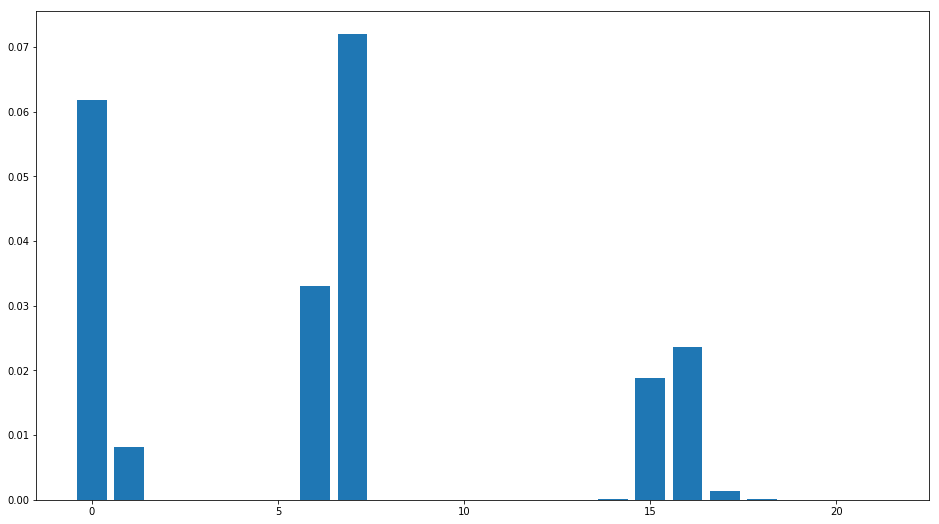

In [43]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,gasoline_flow)


plt.show()

# Open up product mixing and match

In [ ]:
for i,j in model.P_tray:
    if j == 'gasoline':
        model.P_tray[i,j].unfix();
        model.P_tray[i,j].setlb(1e-5);

In [ ]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

In [ ]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Side Draw')

# Open up feed allocation

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [ ]:
# for j in model.reactive:
#     model.reactive[j].F.unfix()
#     model.reactive[j].F.setlb(0)
#     model.reactive[j].F.setub(10)

In [ ]:
# model.total_feed_con = pe.ConstraintList()

In [ ]:
# model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [ ]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [ ]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Feed Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Feed Amount and Location')

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3
        
* Catalyst
    * cat: 0 - 10000

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75 / 0.8
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * sum feed = 10 kmol/s
    
* Total catalyst
    * sum cat = 30000 kg
    
**Objective:**
* Max gasoline production

In [ ]:
# for j in model.reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(0)
#     model.reactive[j].cat.setub(30000)

In [ ]:
# model.total_cat_con = pe.ConstraintList()

In [ ]:
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [ ]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [ ]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

In [ ]:
pdf.close()

In [ ]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [ ]:
# for j in model.TRAY_reactive:
#     print('stage',j,'\n')
#     print('Total Flow\t{}'.format(model.reactive[j].F.value + sum(model.reactive[j].r_total_comp[i].value for i in m.COMP_TOTAL)))
#     for i in m.COMP_TOTAL:
#         if i in m.COMP_FEED:
#             print('{}\t\t{}'.format(i,model.reactive[j].F.value*model.reactive[j].z[i].value + model.reactive[j].r_total_comp[i].value))
#         else:
#             print('{}\t\t{}'.format(i,model.reactive[j].r_total_comp[i].value))